In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
import json,os, sys, glob, datetime
import gl
import xarray as xr
import datetime
import io

import sys
import time
from PyQt5 import QtWidgets, uic, QtCore
from PyQt5.QtWidgets import QFileDialog

from cftime import num2date
import traceback
from pathlib import Path

msgColors={"ERROR": "red",
           "INFO":"blue",
           "RUNTIME":"grey",
           "NONCRITICAL":"red",
           "SUCCESS":"green"
          }

tgtSeass=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan-Mar","Feb-Apr","Mar-May","Apr-Jun","May-Jul","Jun-Aug","Jul-Sep","Aug-Oct","Sep-Nov","Oct-Dec","Nov-Jan","Dec-Feb"]

srcMons=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
          
indexSources={
"IOD-JMA": ["IOD (Dipole Mode Index) from JMA", "https://ds.data.jma.go.jp/tcc/tcc/products/elnino/index/sstindex/base_period_9120/DMI/anomaly"],
"Nino3-JMA":["Nino3 from JMA","https://ds.data.jma.go.jp/tcc/tcc/products/elnino/index/sstindex/base_period_9120/Nino_3/anomaly"],
"Nino4-JMA": ["Nino4 from JMA","https://ds.data.jma.go.jp/tcc/tcc/products/elnino/index/sstindex/base_period_9120/Nino_4/anomaly"]
}

predictandSouces={
"PRCP-CHIRPSp25-IRIDL":["CHIRPS 0.25 deg rainfall from IRI data library",
                     "https://iridl.ldeo.columbia.edu/SOURCES/.UCSB/.CHIRPS/.v2p0/.daily-improved/.global/.0p25/.prcp/{}/mul/T/(1 Jan {})/(31 Dec {})/RANGE/T/({} {}-{})/seasonalAverage/Y/({})/({})/RANGEEDGES/X/({})/({})/RANGEEDGES/-999/setmissing_value/data.nc", "sum"],
}

predictorSouces={
"SST-ERSSTv5-IRIDL":["Sea Surface temperature ERSST v5",
                         "http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan 1979)/(Dec {})/RANGE/T/({} {}-{})/VALUES/T/12/STEP/Y/{}/{}/RANGEEDGES/X/{}/{}/RANGEEDGES/-999/setmissing_value/data.nc"],
}


def showMessage_print(_message, _type="RUNTIME"):
    #this print messages to log window, which are generated outside of the threaded function
    print(_message)

def showMessage(_message, _type="RUNTIME"):
    #this print messages to log window, which are generated outside of the threaded function
    _color=msgColors[_type]
    _message = "<pre><font color={}>{}</font></pre>".format(_color, _message)
    gl.window.log(_message)

    
def downloadUrl(_url):        
    #requesting data
    showMessage("waiting for: {}".format(_url))
    
    response=requests.get(_url)
    showMessage("done")

    #checking if response successful
    if response.status_code!=200:
        print(response)
        return
    
    return response
    


    
def downloadPredictand():
    #read data from gui
    _predictandcode=gl.window.comboBox1_var.currentData()
    _overwrite=gl.window.checkBox1_overwrite.isChecked()
    _predictandyear=gl.window.lineEdit_tgtyear.text()
    _predictandseas=gl.window.comboBox_tgtseas.currentData()    
    south=gl.window.lineEdit1_minlat.text()
    north=gl.window.lineEdit1_maxlat.text()
    west=gl.window.lineEdit1_minlon.text()
    east=gl.window.lineEdit1_maxlon.text()
    
    _downloadsdir=gl.window.lineEditDirectory.text()
    
    if not os.path.exists(_downloadsdir):
        showMessage("output directory {} does not exist. creating...".format(_downloadsdir))
        os.makedirs(downloadsdir)
        showMessage("done")
    
    if _predictandcode=="":
        showMessage("\nplease select variable to download", "ERROR")
        return

    if _predictandyear=="":
        showMessage("\nplease provide predicand's year", "ERROR")
        return
    
    if _predictandseas=="":
        showMessage("\nplease provide predictand's season", "ERROR")
        return

    showMessage_print("\ndownloading {}".format(_predictandcode))

    
    #simply - monthly target will have three letters, seasonal target - 7
    temporalaggregation=predictandSouces[_predictandcode][2]
    
    if len(_predictandseas)==3:
        #monthly
        multiply=1
        basetime="mon"
    else:
        basetime="seas"
        if temporalaggregation=="sum":
            #seasonal with sum
            multiply=3
        else:
            #seasonal with mean
            multiply=1

    _source=_predictandcode.split("-")[-1]
    
    if _source=="IRIDL":

        #defined internally, can be included in the variable-source dictionary
        firstyear=1981
        firstmonth=_predictandseas[0:3]
        first_date=pd.to_datetime("01 {} {}".format(firstmonth, firstyear))
        
        finalyear=_predictandyear
        finalmonth=_predictandseas[-3:]
        
        last_date=pd.to_datetime("01 {} {}".format(finalmonth, finalyear))
        
        
        daterange="{}{}-{}{}".format(_predictandseas[0:3],firstyear, _predictandseas[-3:], finalyear)
        showMessage("requesting date range: {}".format(daterange))

        
        outfile=Path("{}","{}_{}_{}-{}.nc".format(_downloadsdir,_predictandcode, basetime, first_date.strftime("%Y%m"), last_date.strftime("%Y%m")))
        
        if _overwrite is False:
            if os.path.exists(outfile):
                showMessage("file {} exists, and overwrite is OFF. Skipping...".format(outfile),"NONCRITICAL")
                return
        
        url=predictandSouces[_predictandcode][1]
        url=url.format(multiply,firstyear, finalyear, _predictandseas, firstyear, finalyear, south,north,west,east)

        response=downloadUrl(url)
        
        if response is None:
            showMessage("failed to download data")
            return
        else:
            
            data_stream = io.BytesIO(response.content)

            # Open with xarray
            ds = xr.open_dataset(data_stream, decode_times=False)
            
            time_raw = ds['T'].values
            units = ds['T'].attrs.get('units', 'days since 1900-01-01')
            calendar = ds['T'].attrs.get('calendar', 'standard')
            if calendar == '360':
                calendar = '360_day'
            
            time_cftime = num2date(time_raw, units=units, calendar=calendar)
            
            #iridl dates are mid of the season or mid month, aligning them with our notation
            #first month first year, and last month last year
            #back two months
            firstdatadate=pd.to_datetime("{}-{}-15".format(time_cftime[0].year, time_cftime[0].month))-pd.offsets.MonthBegin(2)
            #forward one month
            lastdatadate=pd.to_datetime("{}-{}-15".format(time_cftime[-1].year, time_cftime[-1].month))+pd.offsets.MonthBegin(1)
            if lastdatadate<last_date:
                showMessage("Downloaded data contains data till {}, and thus does not fully cover the the requested period {}".format(last_date.strftime("%b %Y"), daterange), "NONCRITICAL")
            else:
                showMessage("All fine", "NONCRITICAL")
                
            # on successful response - writing raw file
            with open(outfile, "wb") as outf:
                outf.write(response.content)
            showMessage("Saved downloaded data to {}".format(outfile), "SUCCESS")
    

        
def downloadIndexPredictor():
#def downloadIndex(_indexcode, _url, _downloadsdir, _predictordate, _overwrite=False):
    #read data from gui
    _indexcode=gl.window.comboBox4_var.currentData()
    _overwrite=gl.window.checkBox4_overwrite.isChecked()
    _predictoryear=gl.window.lineEdit_srcyear.text()
    _predictormonth=gl.window.comboBox_srcmon.currentData()    
    _predictordate=pd.to_datetime("01 {} {}".format(_predictormonth, _predictoryear))+pd.offsets.MonthEnd()
    
    _downloadsdir=gl.window.lineEditDirectory.text()
    
    if not os.path.exists(_downloadsdir):
        showMessage("output directory {} does not exist. creating...".format(_downloadsdir))
        os.makedirs(downloadsdir)
        showMessage("done")
    
    if _indexcode=="":
        showMessage("\nplease select variable to download", "ERROR")
        return

    if _predictoryear=="":
        showMessage("\nplease provide predictor's year", "ERROR")
        return
    
    if _predictormonth=="":
        showMessage("\nplease provide predictor's month", "ERROR")
        return

    showMessage_print("\ndownloading {}".format(_indexcode))

    _url=indexSources[_indexcode][1]
    
    #requesting data
    response=downloadUrl(_url)

    #index-specific processing
    if _indexcode in ["IOD-JMA","Nino3-JMA","Nino4-JMA"]:
        #processing raw data
        data=response.text.split("\n")
        data=np.array([x.split() for x in data[1:-1]])
        years=data[:,0]
        data=data[:,1:].flatten()
        
        #creating and populating dataframe
        dates=pd.date_range("{}-01-01".format(years[0]), periods=len(data), freq="ME")
        
        _index=_indexcode.split("-")[0]
        output=pd.DataFrame(data, index=dates, columns=[_index]).astype(float)
        output[output==99.90]=np.nan
        output=output[~np.isnan(output).values]
        
    first_date=output.index[0].strftime("%Y%m")
    last_date=output.index[-1].strftime("%Y%m")
    showMessage("downloaded data covers the period of {} to {}".format(first_date, last_date))

    showMessage("checking if predictor date {} in data...".format(_predictordate.strftime("%b %Y")))
    if not _predictordate in output.index:
        showMessage("predictor date {} not in data!".format(_predictordate.strftime("%b %Y")),"NONCRITICAL")
          
    #defining file names
    #rawfile=Path(_downloadsdir,"{}_{}-{}.txt".format(_indexcode, first_date, last_date))
    outfile=Path(_downloadsdir,"{}_{}-{}.csv".format(_indexcode, first_date, last_date))
    
    if _overwrite is False:
        if os.path.exists(outfile):
            showMessage("file {} exists, and overwrite is OFF. Skipping...".format(outfile),"NONCRITICAL")
            return
          
    # on successful response - writing raw file
    #with open(rawfile, "w") as outf:
    #    outf.write(response.text)
    #showMessage("saved raw data to {}".format(rawfile), "SUCCESS")

    #saving file to csv
    output.to_csv(outfile)
    showMessage("saved csv data to {}".format(outfile), "SUCCESS")

    
    
    
    
    
def downloadGriddedPredictor():
    #read data from gui
    _predictorcode=gl.window.comboBox2_var.currentData()
    _overwrite=gl.window.checkBox2_overwrite.isChecked()
    _predictoryear=gl.window.lineEdit_srcyear.text()
    _predictormon=gl.window.comboBox_srcmon.currentData()    
    south=gl.window.lineEdit2_minlat.text()
    north=gl.window.lineEdit2_maxlat.text()
    west=gl.window.lineEdit2_minlon.text()
    east=gl.window.lineEdit2_maxlon.text()
    
    for _x in [south,north,west,east]:
        if _x=="":
            showMessage("\nplease define coordinates of requested domain", "ERROR")
            return
        
    _downloadsdir=gl.window.lineEditDirectory.text()
    
    if not os.path.exists(_downloadsdir):
        showMessage("output directory {} does not exist. creating...".format(_downloadsdir))
        os.makedirs(downloadsdir)
        showMessage("done")
    
    if _predictorcode=="":
        showMessage("\nplease select variable to download", "ERROR")
        return

    if _predictoryear=="":
        showMessage("\nplease provide predictor's year", "ERROR")
        return
    
    if _predictormon=="":
        showMessage("\nplease provide predictor's month", "ERROR")
        return
    
    

    showMessage("\ndownloading {}".format(_predictorcode))
    
    _source=_predictorcode.split("-")[-1]
    
    #always
    basetime="mon"
    
    if _source=="IRIDL":

        #defined internally, can be included in the variable-source dictionary
        firstyear=1981
        firstmonth=_predictormon
        first_date=pd.to_datetime("01 {} {}".format(firstmonth, firstyear))
        
        lastyear=_predictoryear
        lastmonth=_predictormon
        
        last_date=pd.to_datetime("01 {} {}".format(lastmonth, lastyear))
        
        
        daterange="{}{}-{}{}".format(_predictormon,firstyear, _predictormon, lastyear)
        showMessage("requesting date range: {}".format(daterange))

        
        outfile="{}/{}_{}_{}-{}.nc".format(_downloadsdir,_predictorcode, basetime, first_date.strftime("%Y%m"), last_date.strftime("%Y%m"))
        
        if _overwrite is False:
            if os.path.exists(outfile):
                showMessage("file {} exists, and overwrite is OFF. Skipping...".format(outfile),"NONCRITICAL")
                return

        #"http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/
        # (Jan 1982)/(Dec 2021)/RANGE/T/({} {}-{})/VALUES/T/12/STEP/Y/{}/{}/RANGEEDGES/
        # X/{}/{}/RANGEEDGES/-999/setmissing_value/data.nc"
        url=predictorSouces[_predictorcode][1]
        url=url.format(lastyear, _predictormon, firstyear, lastyear, south,north,west,east)

        response=downloadUrl(url)
        
        if response is None:
            showMessage("failed to download data")
            return
        else:
            
            data_stream = io.BytesIO(response.content)

            # Open with xarray
            ds = xr.open_dataset(data_stream, decode_times=False)
            
            time_raw = ds['T'].values
            units = ds['T'].attrs.get('units', 'days since 1900-01-01')
            calendar = ds['T'].attrs.get('calendar', 'standard')
            if calendar == '360':
                calendar = '360_day'
            
            time_cftime = num2date(time_raw, units=units, calendar=calendar)
            
            #iridl dates are mid of the season or mid month, aligning them with our notation
            #first month first year, and last month last year
            #back two months
            firstdatadate=pd.to_datetime("{}-{}-15".format(time_cftime[0].year, time_cftime[0].month))-pd.offsets.MonthBegin(2)
            #forward one month
            lastdatadate=pd.to_datetime("{}-{}-15".format(time_cftime[-1].year, time_cftime[-1].month))+pd.offsets.MonthBegin(1)
            print(lastdatadate, last_date)
            if lastdatadate<last_date:
                showMessage("Downloaded data contains data till {}, and thus does not fully cover the the requested period {}".format(last_date.strftime("%b %Y"), daterange), "NONCRITICAL")
            else:
                showMessage("All fine", "NONCRITICAL")
                
            # on successful response - writing raw file
            with open(outfile, "wb") as outf:
                outf.write(response.content)
            showMessage("Saved downloaded data to {}".format(outfile), "SUCCESS")
        

class Worker(QtCore.QThread):
    log = QtCore.pyqtSignal(str)
    finished = QtCore.pyqtSignal()

    def __init__(self, task_function, *args, **kwargs):
        super().__init__()
        self.task_function = task_function
        self.args = args
        self.kwargs = kwargs

    def run(self):
        """Run the provided function in a thread and emit logs."""
        try:
            self.log.emit("Task started...")
            # Run the task
            self.task_function(*self.args, **self.kwargs)
            self.log.emit("Task finished successfully.")
        except Exception as e:
            tb = traceback.format_exc()
            self.log.emit(f"Error occurred:\n{tb}")
            #self.log.emit(f"Error: {e}")
        finally:
            self.finished.emit()

class MainWindow(QtWidgets.QMainWindow):
    log_signal = QtCore.pyqtSignal(str)
    
    def __init__(self):
        super().__init__()
        uic.loadUi("download.ui", self)
        
        
        # Collect buttons
        self.buttons = [self.button1_run]

        # Connect signals
        self.button1_run.clicked.connect(lambda: self.start_task(downloadPredictand))
        self.button2_run.clicked.connect(lambda: self.start_task(downloadGriddedPredictor))
        self.button4_run.clicked.connect(lambda: self.start_task(downloadIndexPredictor))
        self.clearLogButton.clicked.connect(self.logWindow.clear)
        
        self.log_signal.connect(self.logWindow.appendHtml)
        
        # Set up collapsible groupBox and connect its checkbox signal
        def setup_collapsible(group_box):
            group_box.toggled.connect(
                lambda checked, box=group_box: (
                    [child.setVisible(checked) 
                     for child in box.findChildren(QtWidgets.QWidget) if child is not box]
                )
            )
                        
        for gB in [self.groupBox1, self.groupBox2, self.groupBox3, self.groupBox4]:
            setup_collapsible(gB)
            
        # collapsing
        for gB in [self.groupBox2, self.groupBox3, self.groupBox1]:
            for child in gB.findChildren(QtWidgets.QWidget):
                if child is not gB:
                    child.setVisible(False)
                    
        #file/directory browser
        self.browseButton.clicked.connect(self.browse_directory)

    # ---------- Thread Handling ----------
    def start_task(self, func):
        """Start a task in a background thread and disable buttons."""
        self.set_buttons_enabled(False)
        self.worker = Worker(func)
        self.worker.log.connect(self.logWindow.appendHtml)
        self.worker.finished.connect(lambda: self.set_buttons_enabled(True))
        self.worker.start()

    def set_buttons_enabled(self, enabled: bool):
        for btn in self.buttons:
            btn.setEnabled(enabled)

    def browse_directory(self):
        dir_path = QFileDialog.getExistingDirectory(self, "Select Directory", "")
        if dir_path:
            self.lineEditDirectory.setText(dir_path)
            
    def log(self, message):
        # safe to call from any thread
        self.log_signal.emit(message)            
            
if __name__ == "__main__":
    app = QtWidgets.QApplication(sys.argv)
    gl.window = MainWindow()
    gl.window.show()

    gl.window.comboBox1_var.clear()
    gl.window.comboBox1_var.addItem("", "")
    for key, value in predictandSouces.items():
        gl.window.comboBox1_var.addItem(value[0], key)
        
    gl.window.comboBox2_var.clear()
    gl.window.comboBox2_var.addItem("", "")
    for key, value in predictorSouces.items():
        gl.window.comboBox2_var.addItem(value[0], key)
    
    gl.window.comboBox4_var.clear()
    gl.window.comboBox4_var.addItem("", "")
    for key, value in indexSources.items():
        gl.window.comboBox4_var.addItem(value[0], key)

    gl.window.comboBox_tgtseas.clear()
    gl.window.comboBox_tgtseas.addItem("", "")
    for key in tgtSeass:
        gl.window.comboBox_tgtseas.addItem(key, key)
    
    gl.window.comboBox_srcmon.clear()
    gl.window.comboBox_srcmon.addItem("", "")
    for key in srcMons:
        gl.window.comboBox_srcmon.addItem(key, key)
    
    
gl.config={}
gl.config['downloadDir']="../test_data"
gl.config['predictorMonth'] = "Jun"
gl.config['predictorYear'] = 2025
gl.config['fcstTargetMonth']="Dec"
gl.config['fcstTargetYear']=2025
gl.config['predictorSeas'] = "Mar-May"

gl.config['predictandMinLat']=-34
gl.config['predictandMaxLat']=-30
gl.config['predictandMinLon']=19
gl.config['predictandMaxLon']=22

gl.config['predictorMinLat']=-60
gl.config['predictorMaxLat']=60
gl.config['predictorMinLon']=-180
gl.config['predictorMaxLon']=180

def populateGui():
    gl.window.lineEditDirectory.setText(gl.config['downloadDir'])
    gl.window.lineEdit_tgtyear.setText(str(gl.config['fcstTargetYear']))
    gl.window.lineEdit_srcyear.setText(str(gl.config['predictorYear']))
    gl.window.comboBox_srcmon.setCurrentText(gl.config['predictorMonth'])
    gl.window.comboBox_tgtseas.setCurrentText(gl.config['predictorSeas'])
    gl.window.lineEdit1_minlat.setText(str(gl.config['predictandMinLat']))
    gl.window.lineEdit1_minlon.setText(str(gl.config['predictandMinLon']))
    gl.window.lineEdit1_maxlat.setText(str(gl.config['predictandMaxLat']))
    gl.window.lineEdit1_maxlon.setText(str(gl.config['predictandMaxLon']))
    gl.window.lineEdit2_minlat.setText(str(gl.config['predictorMinLat']))
    gl.window.lineEdit2_minlon.setText(str(gl.config['predictorMinLon']))
    gl.window.lineEdit2_maxlat.setText(str(gl.config['predictorMaxLat']))
    gl.window.lineEdit2_maxlon.setText(str(gl.config['predictorMaxLon']))
    
populateGui()

sys.exit(app.exec_())

    

SystemExit: 0

/home/piotr/mambaforge/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3386: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
#download predictand data
gl.config={}

gl.config['downloadDir']="../test_data"
gl.config['predictorMonth'] = "Jun"
gl.config['predictorYear'] = 2025


gl.config['overwrite']=True

gl.config['var']="SST"
gl.config['source']="ERSSTv5"


north=gl.config['north']
south=gl.config['south']
east=gl.config['east']
west=gl.config['west']
var=gl.config['var']
source=gl.config['source']
target=gl.config['predictorMonth']


downloadDir=gl.config['downloadDir']
overwrite=gl.config['overwrite']

#defined internally
firstYear=1981
basetime="mon"

#finding last year of data
today=datetime.date.today()
finalDate=pd.to_datetime("01 {} {}".format(target, today.year))+pd.offsets.MonthEnd()

#simple check against year, but one can check against months too, because CHIRPS data are available with ~1 month latency
#but IRI does not give problems if request is longer than available data, so...
if finalDate>today+pd.offsets.MonthEnd():
    #subtracting one year
    finalYear=today.year-1
else:
    finalYear=today.year

    
dateRange="{}{}-{}{}".format(target,firstYear, target, finalYear)

#"http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/
# (Jan 1982)/(Dec 2021)/RANGE/T/({} {}-{})/VALUES/T/12/STEP/Y/{}/{}/RANGEEDGES/
# X/{}/{}/RANGEEDGES/-999/setmissing_value/data.nc"
url=predictorSouces[_predictorcode][1]
url=url.format(finalYear, target, firstYear, finalYear, south,north,west,east)


#defining file names
ncfile="{}/{}_{}_{}_{}.nc".format(downloadsDir, var, basetime, source, dateRange)


if overwrite is False:
    if os.path.exists(ncfile):
        showMessage("file {} exists, and overwrite is OFF. Skipping...".format(ncfile))
else:
    downloadIridl(url, ncfile)

NameError: name 'gl' is not defined

In [62]:
ds=xr.open_dataset("../test_data/SST_mon_ERSSTv5_Jun1981-Jun2025.nc", decode_times=False)
coordsubs={"lon":["longitude","X","Longitude","Lon"], "lat":["latitude","Y","Latitude","Lat"], "time":["T"]}
for key in coordsubs.keys():
    for x in coordsubs[key]:
        if x in ds.coords.keys():
            showMessage("\tfound {} - renaming to {}".format(x,key),"RUNTIME")
            ds=ds.rename({x:key})
                
if ds["time"].attrs['calendar'] == '360':
    ds["time"].attrs['calendar'] = '360_day'
ds = xr.decode_cf(ds)
ds=ds.convert_calendar("standard", align_on="date")
ds

	found X - renaming to lon
	found Y - renaming to lat
	found T - renaming to time


<xarray.Dataset> Size: 2MB
Dimensions:  (time: 45, zlev: 1, lat: 71, lon: 181)
Coordinates:
  * zlev     (zlev) float32 4B 0.0
  * time     (time) datetime64[ns] 360B 1981-06-16 1982-06-16 ... 2025-06-16
  * lat      (lat) float32 284B -70.0 -68.0 -66.0 -64.0 ... 64.0 66.0 68.0 70.0
  * lon      (lon) float32 724B 180.0 178.0 176.0 174.0 ... -176.0 -178.0 -180.0
Data variables:
    sst      (time, zlev, lat, lon) float32 2MB -1.8 -1.8 -1.8 ... -1.8 -1.8

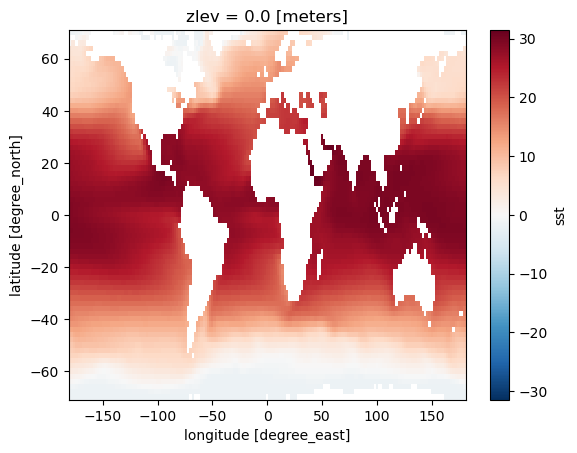

In [63]:
ds["sst"].mean("time").plot()